<a href="https://colab.research.google.com/github/heokwon/Data-Handling-for-Competiton/blob/main/convert_dataset_with_stride.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

reference : https://www.kaggle.com/code/e0xextazy/multiclass-dataset-768x768-with-stride-for-mmseg

In [1]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.3 MB/s 


In [1]:
import gc
import os
import cv2
import zipfile
import rasterio
import numpy as np
import pandas as pd
from PIL import Image
import tifffile as tiff
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from rasterio.windows import Window
from torch.utils.data import Dataset

## Check the resolution distribution 

In [ ]:
!gdown 1YdWghK4bmETtCE3_KIwLpSmgFv5kpVaN
!unzip /content/hubmap-organ-segmentation.zip

3000_3000    326
2631_2631      2
2416_2416      2
2942_2942      2
2790_2790      2
2764_2764      2
2654_2654      2
2539_2539      1
2680_2680      1
2727_2727      1
2308_2308      1
2867_2867      1
2783_2783      1
2869_2869      1
2760_2760      1
2630_2630      1
2511_2511      1
2593_2593      1
2675_2675      1
3070_3070      1
Name: resolution, dtype: int64


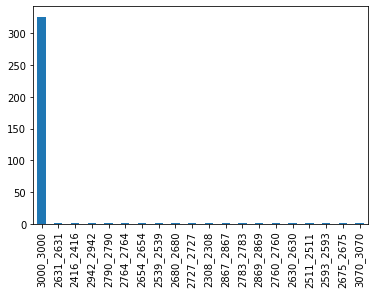

In [2]:
train_df = pd.read_csv("/content/train.csv")
train_df['resolution'] = train_df.apply(lambda x: str(x.img_height) + '_' + str(x.img_width), axis=1)
train_df.resolution.value_counts().plot(kind='bar')
print(train_df.resolution.value_counts())

## Generating

In [5]:
!mkdir hubmap-organ-segmentation
!mv ./train_images ./hubmap-organ-segmentation
!mv ./test_images ./hubmap-organ-segmentation

In [12]:
!rm ./4_train.zip ./4_masks.zip

In [3]:
OUT_TRAIN = '3_train.zip'
OUT_MASKS = '3_masks.zip'
sz = 512   # the size of tiles
reduce = 3 # reduce the original images by n times 
stride = 256
MASKS = './train.csv'
DATA = './hubmap-organ-segmentation/train_images'

In [4]:
# functions to convert encoding to mask and mask to encoding
def enc2mask(mask_rle, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2enc(mask, n=1):
    pixels = mask.T.flatten()
    encs = []
    for i in range(1,n+1):
        p = (pixels == i).astype(np.int8)
        if p.sum() == 0: encs.append(np.nan)
        else:
            p = np.concatenate([[0], p, [0]])
            runs = np.where(p[1:] != p[:-1])[0] + 1
            runs[1::2] -= runs[::2]
            encs.append(' '.join(str(x) for x in runs))
    return encs

# mask_map = dict(
#     kidney=1,
#     prostate=2,
#     largeintestine=3,
#     spleen=4,
#     lung=5)#add

df_masks = pd.read_csv(MASKS)[['id', 'organ', 'rle']].set_index('id')#add
df_masks.head()

,organ,rle
id,,
10044,prostate,1459676 77 1462675 82 1465674 87 1468673 92 14...
10274,prostate,715707 2 718705 8 721703 11 724701 18 727692 3...
10392,spleen,1228631 20 1231629 24 1234624 40 1237623 47 12...
10488,lung,3446519 15 3449517 17 3452514 20 3455510 24 34...
10610,spleen,478925 68 481909 87 484893 105 487863 154 4908...


In [5]:
s_th = 40  # saturation blancking threshold
p_th = 1000*(sz // 256) ** 2 # threshold for the minimum number of pixels


class HuBMAPDataset(Dataset):
    def __init__(self, idx, sz=sz, reduce=reduce, stride=stride, encs=None):
        self.data = rasterio.open(os.path.join(DATA,str(idx)+'.tiff'),num_threads='all_cpus')
        if self.data.count != 3:
            subdatasets = self.data.subdatasets
            self.layers = []
            if len(subdatasets) > 0:
                for i, subdataset in enumerate(subdatasets, 0):
                    self.layers.append(rasterio.open(subdataset))
        self.shape = self.data.shape 
        self.reduce = reduce 
        self.sz = reduce*sz 
        self.stride = reduce*stride
        assert self.stride < self.sz, "stride must be less than window size"
        self.pad0 = abs(self.shape[0] - (max((self.shape[0]//self.stride)-(self.sz//self.stride), 0)*self.stride + self.sz))
        self.pad1 = abs(self.shape[0] - (max((self.shape[1]//self.stride)-(self.sz//self.stride), 0)*self.stride + self.sz))
#         self.pad0 = (self.sz - self.shape[0]%self.sz)%self.sz # 1096
#         self.pad1 = (self.sz - self.shape[1]%self.sz)%self.sz
        assert self.pad0 < self.stride, "func is broken, pls check bug"
        assert self.pad1 < self.stride, "func is broken, pls check bug"
        self.n0max = (self.shape[0] + self.pad0 - self.sz)//self.stride + 1
        self.n1max = (self.shape[1] + self.pad1 - self.sz)//self.stride + 1
        self.mask = enc2mask(encs,(self.shape[1],self.shape[0])) if encs is not None else None
        
    def __len__(self):
        return self.n0max*self.n1max
    
    def __getitem__(self, idx):
        n0,n1 = idx//self.n0max, idx%self.n1max
        # x0,y0 - are the coordinates of the lower left corner of the tile in the image
        # negative numbers correspond to padding (which must not be loaded)
        x0,y0 = -self.pad0//2 + n0*self.stride, -self.pad1//2 + n1*self.stride

        # make sure that the region to read is within the image
        p00,p01 = max(0,x0), min(x0+self.sz,self.shape[0])
        p10,p11 = max(0,y0), min(y0+self.sz,self.shape[1])
        img = np.zeros((self.sz,self.sz,3),np.uint8)
        mask = np.zeros((self.sz,self.sz),np.uint8)
        # mapping the loade region to the tile
        if self.data.count == 3:
            img[(p00-x0):(p01-x0),(p10-y0):(p11-y0)] = np.moveaxis(self.data.read([1,2,3],
                window=Window.from_slices((p00,p01),(p10,p11))), 0, -1)
        else:
            for i,layer in enumerate(self.layers):
                img[(p00-x0):(p01-x0),(p10-y0):(p11-y0),i] =\
                  layer.read(1,window=Window.from_slices((p00,p01),(p10,p11)))
        if self.mask is not None: mask[(p00-x0):(p01-x0),(p10-y0):(p11-y0)] = self.mask[p00:p01,p10:p11]
        
        if self.reduce != 1:
            img = cv2.resize(img,(self.sz//reduce,self.sz//reduce),
                             interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask,(self.sz//reduce,self.sz//reduce),
                             interpolation = cv2.INTER_NEAREST)
        #check for empty imges
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h,s,v = cv2.split(hsv)
        #return -1 for empty images
        return img, mask, (-1 if (s>s_th).sum() <= p_th or img.sum() <= p_th else idx)

In [7]:
x_tot,x2_tot = [],[]
mask_ = [] #add
with zipfile.ZipFile(OUT_TRAIN, 'w') as img_out,\
 zipfile.ZipFile(OUT_MASKS, 'w') as mask_out:
    for index,(organ, encs) in tqdm(df_masks.iterrows(),total=len(df_masks)):#add
        ds = HuBMAPDataset(index,encs=encs)
        for i in range(len(ds)):
            im,m,idx = ds[i]
            if idx < 0: continue
            
            x_tot.append((im/255.0).reshape(-1,3).mean(0))
            x2_tot.append(((im/255.0)**2).reshape(-1,3).mean(0))
            # m = mask_map[organ]*m #add
            # for e in np.unique(m): #add
            #     mask_.append(e) #add
            im = cv2.imencode('.png',cv2.cvtColor(im, cv2.COLOR_RGB2BGR))[1]
            img_out.writestr(f'{index}_{idx:04d}.png', im)
            m = cv2.imencode('.png',m)[1]
            mask_out.writestr(f'{index}_{idx:04d}.png', m)
        
#image stats
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:',img_avr, ', std:',img_std)
# print('classes of mask', set(mask_)) #add

  0%|          | 0/351 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


mean: [0.67343264 0.64264552 0.66397649] , std: [0.31051656 0.31411691 0.31712068]


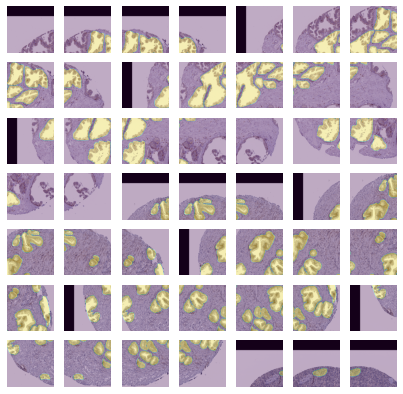

In [17]:
columns, rows = 7,7
idx0 = 0
fig=plt.figure(figsize=(columns, rows))
with zipfile.ZipFile(OUT_TRAIN, 'r') as img_arch, \
     zipfile.ZipFile(OUT_MASKS, 'r') as msk_arch:
    fnames = sorted(img_arch.namelist())
    for i in range(rows):
        for j in range(columns):
            idx = i+j*columns
            img = cv2.imdecode(np.frombuffer(img_arch.read(fnames[idx0+idx]), 
                                             np.uint8), cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            mask = cv2.imdecode(np.frombuffer(msk_arch.read(fnames[idx0+idx]), 
                                              np.uint8), cv2.IMREAD_GRAYSCALE)
    
            fig.add_subplot(rows, columns, idx+1)
            plt.axis('off')
            plt.imshow(Image.fromarray(img))
            plt.imshow(Image.fromarray(mask), alpha=0.3)
plt.show()

In [18]:
# !mkdir 512_2_3_6_stirde_dataset
# !mkdir ./512_2_3_6_stirde_dataset/train
# !mkdir ./512_2_3_6_stirde_dataset/masks

In [ ]:
# !unzip ./2_train.zip -d ./512_2_3_6_stirde_dataset/train
# !unzip ./2_masks.zip -d ./512_2_3_6_stirde_dataset/masks
# !unzip ./3_train.zip -d ./512_2_3_6_stirde_dataset/train
# !unzip ./3_masks.zip -d ./512_2_3_6_stirde_dataset/masks
!unzip ./6_train.zip -d ./512_2_3_6_stirde_dataset/train
!unzip ./6_masks.zip -d ./512_2_3_6_stirde_dataset/masks

In [11]:
len(os.listdir('/content/512_2_3_6_stirde_dataset/train')),len(os.listdir('/content/512_2_3_6_stirde_dataset/masks'))

(11288, 11288)

In [ ]:
!zip 512_2_3_6_stride_dataset.zip -r ./512_2_3_6_stride_dataset

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
!mv ./512_2_3_6_stride_dataset.zip ./drive/MyDrive/data